<a href="https://colab.research.google.com/github/Lukehsu1999/BraTS2025/blob/main/PE_Segmentation_monai_3d_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

In [2]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# # Set the path to your ZIP file in Drive
# zip_path = "/content/drive/MyDrive/FUMPE/CT_scans.zip"
# extract_to = "/content/drive/MyDrive/FUMPE/CT_scans"

# # Create destination folder if it doesn't exist
# os.makedirs(extract_to, exist_ok=True)

# # Extract the zip file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

# print("✅ Extraction complete!")

✅ Extraction complete!


In [3]:
# # Set the path to your ZIP file in Drive
# zip_path = "/content/drive/MyDrive/FUMPE/GroundTruth.zip"
# extract_to = "/content/drive/MyDrive/FUMPE/GroundTruth"

# # Create destination folder if it doesn't exist
# os.makedirs(extract_to, exist_ok=True)

# # Extract the zip file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

# print("✅ Extraction complete!")

✅ Extraction complete!


## Setup environment

In [3]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2025-05-27 06:37:27.431091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748327847.704082   16637 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748327847.778317   16637 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 06:37:28.391404: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Setup imports

In [4]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    ScaleIntensityRangePercentilesd,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.5.dev2521
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: b82b3ff93efc25aff2eee158e3acaab717973590
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 11.2.1
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.51.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.htm

## Wandb Logging

In [5]:
import wandb

# --- Configs from your WandB init ---
epochs = 50
lr = 1e-4
batch_size = 2
loss_func = "DiceLoss"
model = "3D UNet"
modality = "T1c"

train_cnt, val_cnt, test_cnt = 25, 10, 100

# --- WandB ---
run = wandb.init(
    project="PE-Seg",
    name="FUMPE_exp1",
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "loss_func": loss_func,
        "model": model,
        "train_cnt": train_cnt,
        "val_cnt": val_cnt,
        "test_cnt": test_cnt,
        "modality": modality,
    },
    reinit=True,
    settings=wandb.Settings(code_dir="")
)

wandb: Currently logged in as: lukehsu1999 (luke-cmuh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpvxjc2pmx


## Mount on Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set MSD Spleen dataset path

In [8]:
import glob
import os

ct_dir = "/content/drive/MyDrive/FUMPE/CT_scans"
gt_dir = "/content/drive/MyDrive/FUMPE/GroundTruth"

# Recursively find FLAIR and binary mask pairs
image_paths = sorted(glob.glob(os.path.join(ct_dir, "**", "*.nii.gz"), recursive=True))
label_paths = sorted(glob.glob(os.path.join(gt_dir, "**", "*.nii.gz"), recursive=True))

# Make sure they align
assert len(image_paths) == len(label_paths), "Mismatch in image and label counts!"

data_dicts = [{"image": i, "label": l} for i, l in zip(image_paths, label_paths)]

print(data_dicts)

# Manual split: last N for validation
train_files = data_dicts[:-val_cnt]  # adjust N based on your total case count
val_files   = data_dicts[-val_cnt:]

print(f"✅ Total cases: {len(data_dicts)}")
print(f"📊 Training: {len(train_files)}  | Validation: {len(val_files)}")

[{'image': '/content/drive/MyDrive/FUMPE/CT_scans/CT_scans/PAT001/5_.nii.gz', 'label': '/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT001_mask.nii.gz'}, {'image': '/content/drive/MyDrive/FUMPE/CT_scans/CT_scans/PAT002/5_.nii.gz', 'label': '/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT002_mask.nii.gz'}, {'image': '/content/drive/MyDrive/FUMPE/CT_scans/CT_scans/PAT003/7_.nii.gz', 'label': '/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT003_mask.nii.gz'}, {'image': '/content/drive/MyDrive/FUMPE/CT_scans/CT_scans/PAT004/5_.nii.gz', 'label': '/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT004_mask.nii.gz'}, {'image': '/content/drive/MyDrive/FUMPE/CT_scans/CT_scans/PAT005/5_.nii.gz', 'label': '/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT005_mask.nii.gz'}, {'image': '/content/drive/MyDrive/FUMPE/CT_scans/CT_scans/PAT006/7_.nii.gz', 'label': '/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT006_mask.nii.gz'}, {'image': '/content/drive/M

## Set deterministic training for reproducibility

In [9]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [10]:
# from monai.transforms import SpatialPadd
# pad_roi = (64, 96, 64)

# train_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image", "label"]),
#         ScaleIntensityRangePercentilesd(
#             keys=["image"],
#             lower=0.5,     # 0.5 percentile
#             upper=99.5,    # 99.5 percentile
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
#         SpatialPadd(keys=["image", "label"], spatial_size=pad_roi),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(64, 96, 64),
#             pos=1,
#             neg=1,
#             num_samples=4,
#             image_key="image",
#             image_threshold=0,
#         ),
#         # user can also add other random transforms
#         # RandAffined(
#         #     keys=['image', 'label'],
#         #     mode=('bilinear', 'nearest'),
#         #     prob=1.0, spatial_size=(96, 96, 96),
#         #     rotate_range=(0, 0, np.pi/15),
#         #     scale_range=(0.1, 0.1, 0.1)),
#     ]
# )
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image", "label"]),
#         ScaleIntensityRangePercentilesd(
#             keys=["image"],
#             lower=0.5,     # 0.5 percentile
#             upper=99.5,    # 99.5 percentile
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
#     ]
# )

In [11]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, Orientationd,
    Spacingd, RandCropByPosNegLabeld, SpatialPadd
)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-1000, a_max=500,     # Lung window
            b_min=0.0, b_max=1.0,
            clip=True,
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        #Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.5), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 64),  # Smaller patch focuses better
            pos=3,                      # More positives
            neg=1,
            num_samples=6,             # More tries per volume
            image_key="image",
            image_threshold=0,
        ),
    ]
)

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-1000, a_max=500,
        b_min=0.0, b_max=1.0,
        clip=True,
    ),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    #Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.5), mode=("bilinear", "nearest")),
    # optionally pad if needed (some validation images might be small after spacing)
    SpatialPadd(keys=["image", "label"], spatial_size=(96, 96, 64)),
])


## Check transforms in DataLoader

image shape: torch.Size([512, 512, 213]), label shape: torch.Size([512, 512, 213])


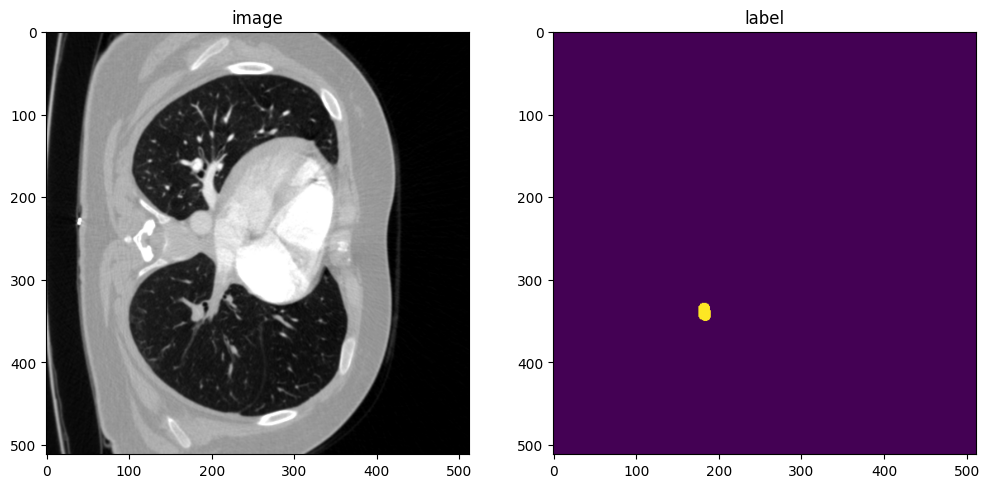

In [12]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 20]
idx = 100
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, idx], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, idx])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [13]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.2, num_workers=2)
#train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=0.2, num_workers=2)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 2/2 [00:16<00:00,  8.10s/it]


In [29]:
import numpy as np
import nibabel as nib

for sample in train_files:
    label_path = sample["label"]
    label = nib.load(label_path).get_fdata()
    print(f"{label_path} | Unique values: {np.unique(label)} | Sum: {label.sum()}")


/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT001_mask.nii.gz | Unique values: [0. 1.] | Sum: 19054.0
/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT002_mask.nii.gz | Unique values: [0. 1.] | Sum: 1548.0
/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT003_mask.nii.gz | Unique values: [0. 1.] | Sum: 35250.0
/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT004_mask.nii.gz | Unique values: [0. 1.] | Sum: 5960.0
/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT005_mask.nii.gz | Unique values: [0. 1.] | Sum: 92229.0
/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT006_mask.nii.gz | Unique values: [0. 1.] | Sum: 1966.0
/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT007_mask.nii.gz | Unique values: [0. 1.] | Sum: 162336.0
/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT008_mask.nii.gz | Unique values: [0. 1.] | Sum: 10496.0
/content/drive/MyDrive/FUMPE/GroundTruth/GroundTruth/PAT009_mask.nii.gz | Unique values: [0. 1.] | Sum: 21

In [15]:
from monai.transforms import LoadImage, Compose, Orientation, Spacing

check_pipeline = Compose([
    LoadImage(image_only=True),
    Orientation(axcodes="RAS"),
])

seg_path = train_files[0]["label"]
seg_img = check_pipeline(seg_path)
print("Shape:", seg_img.shape)
print("Sum of PE mask after spacing:", seg_img.sum())

Shape: torch.Size([512, 512, 201])
Sum of PE mask after spacing: metatensor(19054.)


In [19]:
from monai.utils import first
import numpy as np

sample = first(train_loader)

print("📦 Batch shape:", sample["image"].shape)  # (B, C, H, W, D)

for i in range(sample["label"].shape[0]):
    label_patch = sample["label"][i][0]  # [0] = squeeze channel
    pe_voxels = label_patch.sum().item()
    print(f"🧠 Patch {i}: PE voxels = {pe_voxels}")


📦 Batch shape: torch.Size([12, 1, 96, 96, 64])
🧠 Patch 0: PE voxels = 6258.0
🧠 Patch 1: PE voxels = 7432.0
🧠 Patch 2: PE voxels = 6327.0
🧠 Patch 3: PE voxels = 0.0
🧠 Patch 4: PE voxels = 6266.0
🧠 Patch 5: PE voxels = 6392.0
🧠 Patch 6: PE voxels = 7214.0
🧠 Patch 7: PE voxels = 7040.0
🧠 Patch 8: PE voxels = 14723.0
🧠 Patch 9: PE voxels = 0.0
🧠 Patch 10: PE voxels = 7495.0
🧠 Patch 11: PE voxels = 12917.0


## Create Model, Loss, Optimizer

In [16]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [20]:
from tqdm import tqdm, trange
import warnings
warnings.filterwarnings("ignore", message=".*unable to generate class balanced samples.*")


In [ ]:
max_epochs = 20
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])


epoch_range = trange(max_epochs, desc="Training Epochs")

for epoch in epoch_range:
    #print("-" * 10)
    #print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    epoch_range.set_postfix({"loss": epoch_loss})
    wandb.log({"train/loss": epoch_loss}, step=epoch)
    #print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)

            wandb.log({"val/dice": metric}, step=epoch)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            # print(
            #     f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            #     f"\nbest mean dice: {best_metric:.4f} "
            #     f"at epoch: {best_metric_epoch}"
            # )

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

1/12, train_loss: 0.6152
2/12, train_loss: 0.6131
3/12, train_loss: 0.6037
4/12, train_loss: 0.6138
5/12, train_loss: 0.5825
6/12, train_loss: 0.6074
7/12, train_loss: 0.6100
8/12, train_loss: 0.6121
9/12, train_loss: 0.5921
10/12, train_loss: 0.6044
11/12, train_loss: 0.5792
12/12, train_loss: 0.5784


Training Epochs:   0%|          | 0/20 [03:37<?, ?it/s, loss=0.6]

13/12, train_loss: 0.5867


Training Epochs:   5%|▌         | 1/20 [05:30<1:44:42, 330.68s/it, loss=0.6]

saved new best metric model
1/12, train_loss: 0.6093
2/12, train_loss: 0.6051
3/12, train_loss: 0.5821
4/12, train_loss: 0.6053
5/12, train_loss: 0.5326
6/12, train_loss: 0.5960
7/12, train_loss: 0.6023
8/12, train_loss: 0.5788
9/12, train_loss: 0.5965
10/12, train_loss: 0.6035
11/12, train_loss: 0.5992
12/12, train_loss: 0.5889
13/12, train_loss: 0.5420


Training Epochs:   5%|▌         | 1/20 [08:59<1:44:42, 330.68s/it, loss=0.588]

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.5179 at epoch: 576


## Plot the loss and metric

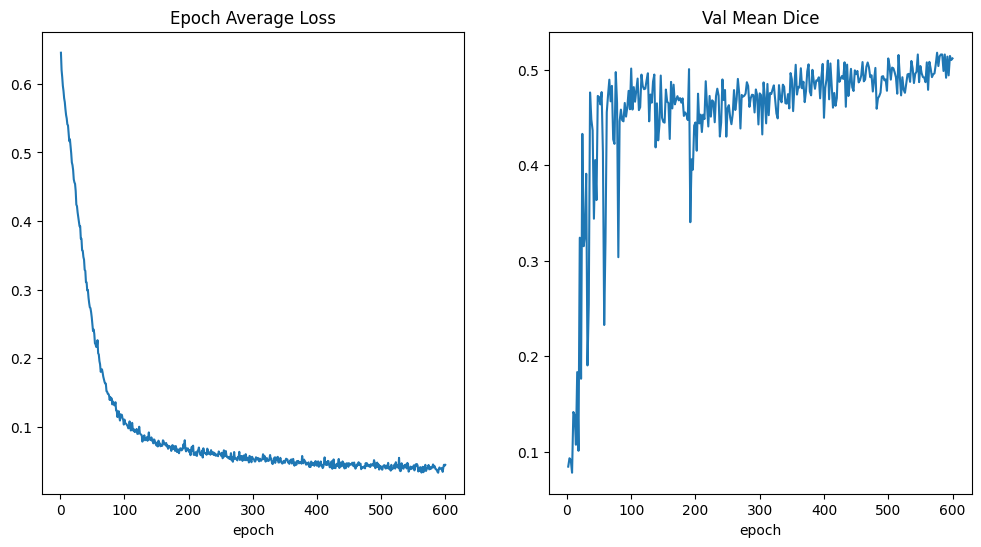

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

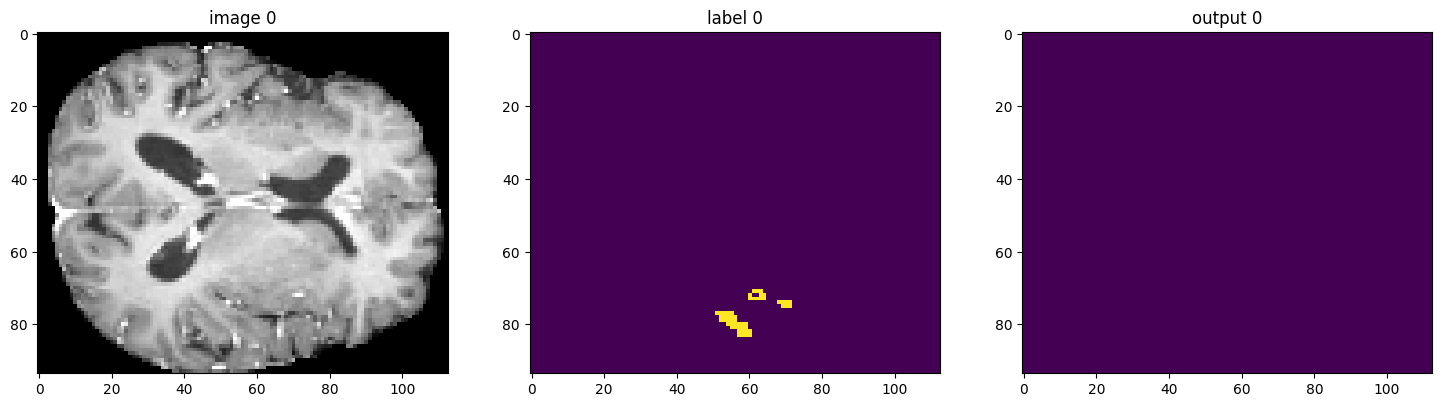

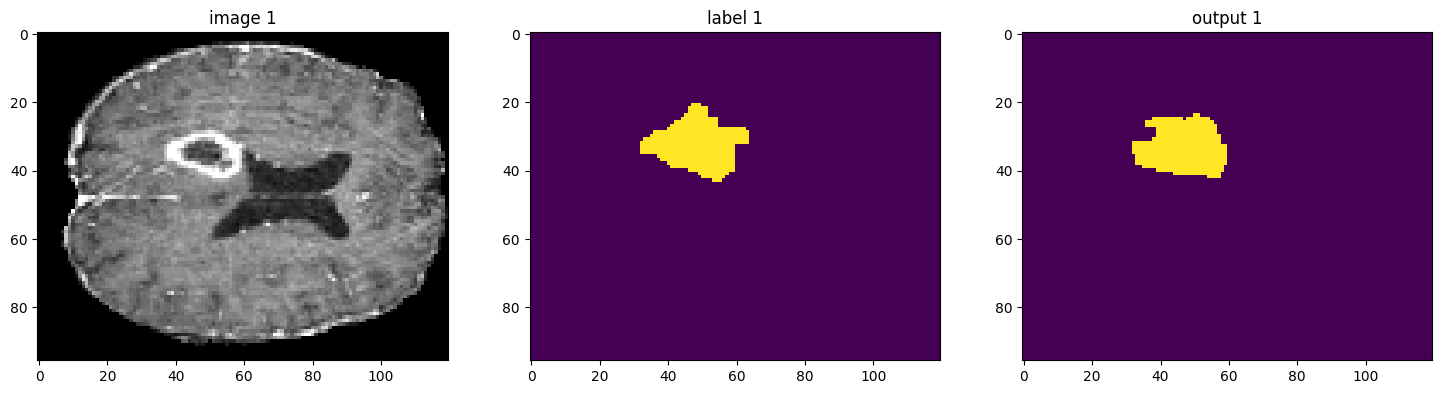

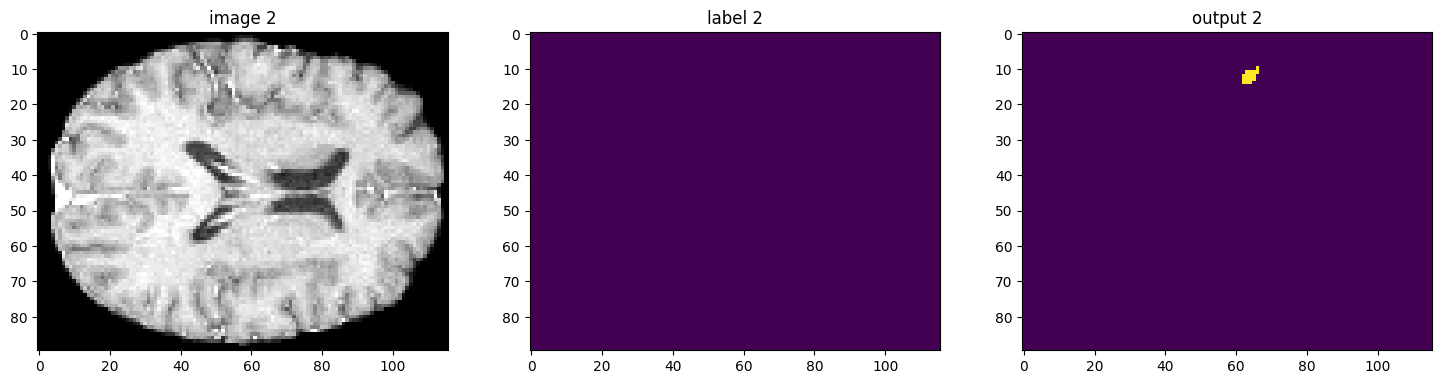

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        idx = 40
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :,idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, idx])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, idx])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRangePercentilesd(
            keys=["image"],
            lower=0.5,     # 0.5 percentile
            upper=99.5,    # 99.5 percentile
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image", allow_smaller=True),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.5191232562065125


In [ ]:
wandb.config.update({"val_metric_orig_spacing": metric_org})

## Inference on Test Set

In [ ]:
test_dir = "/content/drive/MyDrive/BraTS2025/static_test_set"

test_images = sorted(glob.glob(os.path.join(test_dir, "**", "*t2f.nii.gz"), recursive=True))
test_labels = sorted(glob.glob(os.path.join(test_dir, "**", "*seg_binary.nii.gz"), recursive=True))



test_data = [{"image": img, "label": lbl} for img, lbl in zip(test_images, test_labels)]


test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ScaleIntensityRangePercentilesd(
            keys=["image"],
            lower=0.5,     # 0.5 percentile
            upper=99.5,    # 99.5 percentile
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
    CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
])

# === 3. Dataset & Loader ===
test_ds = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

# === 4. Post transforms ===
post_transforms = Compose([
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    AsDiscreted(keys="label", to_onehot=2),
])

# === 5. Metric ===
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=True)

# === 6. Load Model ===
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.to(device)
model.eval()

# === 7. Inference & Evaluation ===
with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_labels = test_data["label"].to(device)

        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        # Post-processing
        test_data = decollate_batch(test_data)
        test_outputs = decollate_batch(test_outputs)

        test_data = [{"pred": p, "label": d["label"]} for p, d in zip(test_outputs, test_data)]
        test_data = [post_transforms(i) for i in test_data]

        preds = [i["pred"].to(device) for i in test_data]
        labels = [i["label"].to(device) for i in test_data]

        dice_metric(y_pred=preds, y=labels)

# === 8. Final Dice Score ===
metric, _ = dice_metric.aggregate()
metric = metric.item()
print(f"✅ Mean Dice on Test Set: {metric:.4f}")
dice_metric.reset()

✅ Mean Dice on Test Set: 0.2859


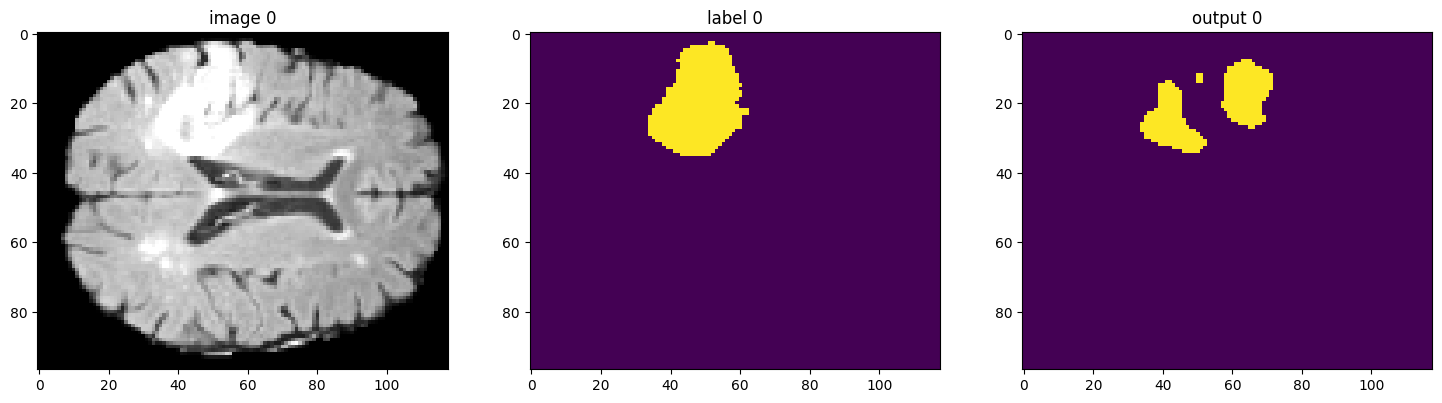

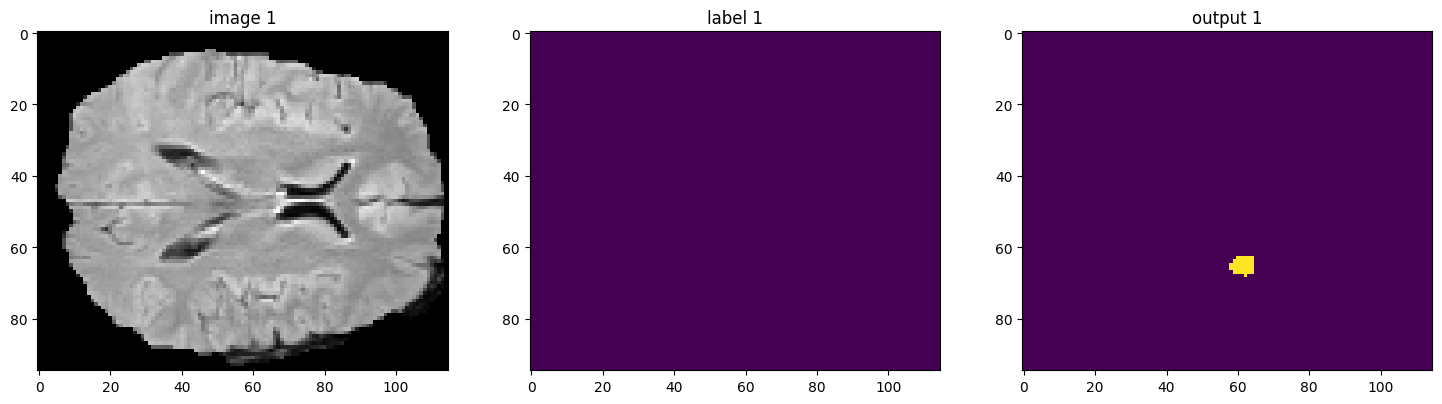

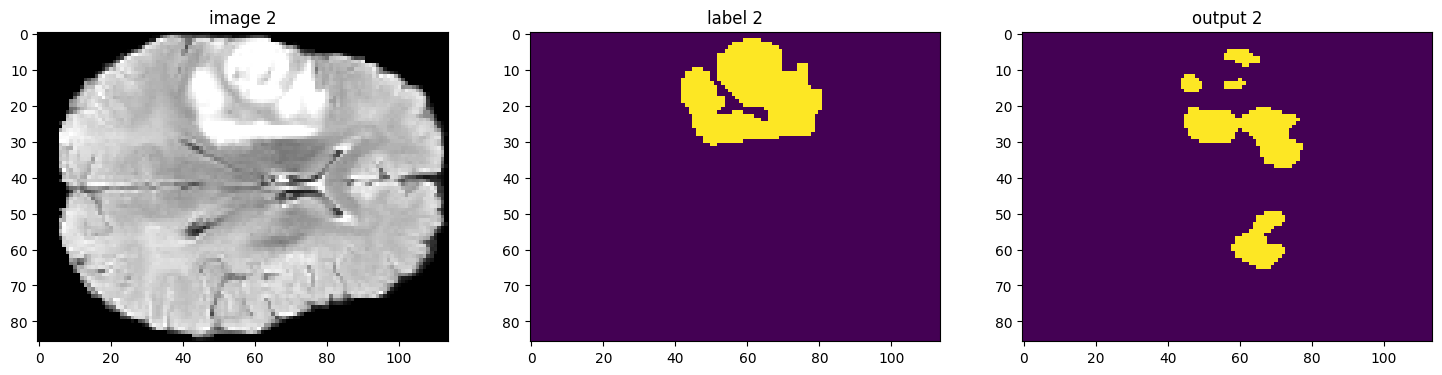

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(test_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        idx = 40
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_data["image"][0, 0, :, :,idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_data["label"][0, 0, :, :, idx])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, idx])
        plt.show()
        if i == 2:
            break

In [ ]:
print(metric)

0.28586485981941223


In [ ]:
wandb.log({"test/dice_mean": metric}, step=0)

In [ ]:
# # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

In [ ]:
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
# model.eval()

# with torch.no_grad():
#     for test_data in test_org_loader:
#         test_inputs = test_data["image"].to(device)
#         roi_size = (160, 160, 160)
#         sw_batch_size = 4
#         test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

#         test_data = [post_transforms(i) for i in decollate_batch(test_data)]

# #         # uncomment the following lines to visualize the predicted results
# #         test_output = from_engine(["pred"])(test_data)

# #         original_image = loader(test_output[0].meta["filename_or_obj"])

# #         plt.figure("check", (18, 6))
# #         plt.subplot(1, 2, 1)
# #         plt.imshow(original_image[:, :, 20], cmap="gray")
# #         plt.subplot(1, 2, 2)
# #         plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
# #         plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)